# 2. Fourier spectral
This notebook demonstrates solving the 1D Burgers Equation using the spectral methods Fourier Galerkin and Fourier pseudospectral.

We'll:
- Import our project modules (`BurgersEquation` and `SpectralFourier`).
- Run a simulation.
- Plot the results and compare snapshots.

In [4]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.FourierSpectral
using Plots

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`


In [5]:
# Parameter choices:
Nx   = 1024    # spatial resolution
dt   = 5e-4/pi   # time step
tmax = 3/pi    # final time
nu  = 1e-2/pi # viscosity
alias_factor = 2/3 # 2/3 rule for Fourier Galerkin

x, u_final, tvec, history = solveFourier(Nx; dt=dt, tmax=tmax, nu=nu, alias_factor=alias_factor)

println("Simulation complete!")
println("Final time = ", tvec[end])

Simulation complete!
Final time = 0.9547705036082802


## Plot the final solution

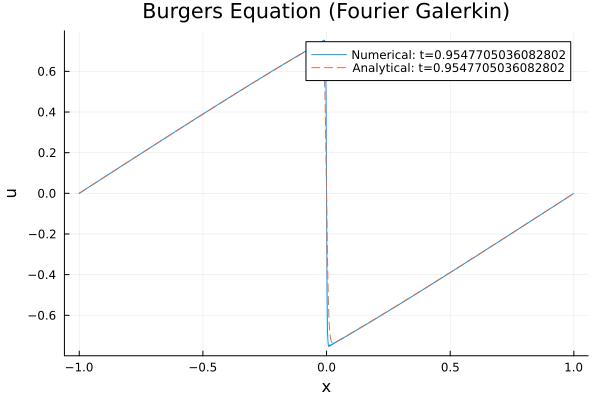

In [6]:
plt = plot(x, u_final, label="Numerical: t=$(tvec[end])", xlabel="x", ylabel="u", 
           title="Burgers Equation (Fourier Galerkin)")
plot!(plt, x, analytical_solution(x, tvec[end]; nu=nu), label="Analytical: t=$(tvec[end])", 
      linestyle=:dash)
display(plt)

## Show multiple snapshots

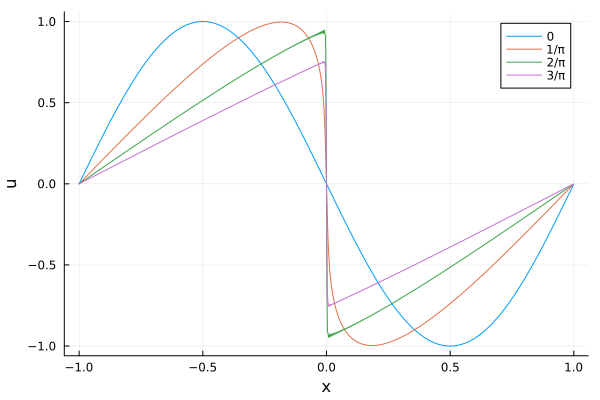

In [7]:
times_to_plot = 0:1/pi:tmax

plt = plot()
for (idx, t) in enumerate(times_to_plot)
    current_label = idx == 1 ? "0" : "$(idx-1)/π"
    plot!(plt, x, history[idx], label=current_label)
end
plot!(plt, xlabel="x", ylabel="u")
display(plt)

In [6]:
history

3-element Vector{Vector{Float64}}:
 [1.2246467991473532e-16, 0.006135884649154799, 0.012271538285720007, 0.0184067299058051, 0.024541228522912326, 0.030674803176636865, 0.03680722294135883, 0.04293825693494102, 0.049067674327417966, 0.055195244349690094  …  -0.06132073630220849, -0.055195244349690094, -0.049067674327417966, -0.04293825693494102, -0.03680722294135883, -0.030674803176636865, -0.024541228522912326, -0.0184067299058051, -0.012271538285720007, -0.006135884649154799]
 [6.268465808089076e-18, 0.0019735049433092233, 0.004152647335762205, 0.0061282191684696175, 0.008099648189689779, 0.010278731204090008, 0.01225636061301294, 0.014225704953027274, 0.016404669208347822, 0.018384346593009138  …  -0.020351597759241488, -0.01838434659300927, -0.016404669208347836, -0.014225704953027184, -0.01225636061301301, -0.010278731204089987, -0.008099648189689793, -0.006128219168469597, -0.004152647335762129, -0.0019735049433091123]
 [3.747230220868257e-17, 0.0012233649906884941, 0.00245402594